# Import data

In [3]:
!pip install seaborn --user

  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import tensorflow as tf
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import seaborn as sns
from sklearn import datasets, metrics

%matplotlib inline

Using TensorFlow backend.


# Classificando imagens em Landmarks

## Lendo o conjunto de dados

In [5]:
seed = random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = '/media/slow/data/landmarks'
target_size = (100, 100)
input_shape = (100, 100, 3)
classes = ["47378", "120885", "85758", "180901", "48522", "101399", 
           "190822", "97734", "146250", "186080", "21253", "142644", 
           "31531", "165596", "56827", "38482", "20102", "178519", 
           "152827", "173511"]


sample_generator = sample_datagen.flow_from_directory(base_path + '/subset_train',
                                                      target_size=target_size,
                                                      batch_size=32,
                                                      class_mode="sparse",
                                                      seed = seed)

sample_test_generator = sample_datagen.flow_from_directory(base_path + "/subset_test",
                                                           target_size = target_size,
                                                           batch_size = 32,
                                                           class_mode = "categorical",
                                                           seed = seed)

x_sample, y_sample = sample_generator.next()
x_sample_test, y_sample_test = sample_test_generator.next()
print('\n')
print('Showing y sample:', y_sample)
print('\n')
print('samples in train: %i' % sample_generator.labels.shape,
      'samples in test: %i' % sample_test_generator.labels.shape,
      'features: %s' % str(x_sample.shape[1:]),
      'classes: %i' % (np.max(sample_generator.labels) + 1),
      sep='\n', end='\n\n')

print('shape:', x_sample.shape, x_sample_test.shape)

Found 12508 images belonging to 20 classes.
Found 3128 images belonging to 20 classes.


Showing y sample: [ 4.  3. 11.  5.  8. 12. 11.  6.  6. 14. 14. 17.  7. 18. 17. 18.  7.  5.
  0.  6. 16. 13.  0.  3.  1. 15.  1. 10.  3.  1.  2. 18.]


samples in train: 12508
samples in test: 3128
features: (100, 100, 3)
classes: 20

shape: (32, 100, 100, 3) (32, 100, 100, 3)


## Lendo as 32 primeiras amostras no conjunto de treinamento

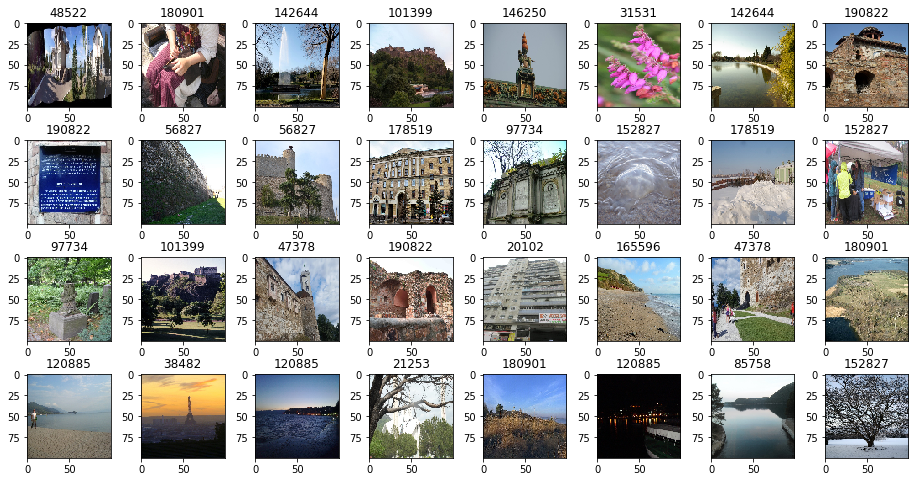

In [6]:
plt.figure(figsize=(16, 8))
for i in range(4 * 8):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

## Visualizando frequência das classes no conjunto

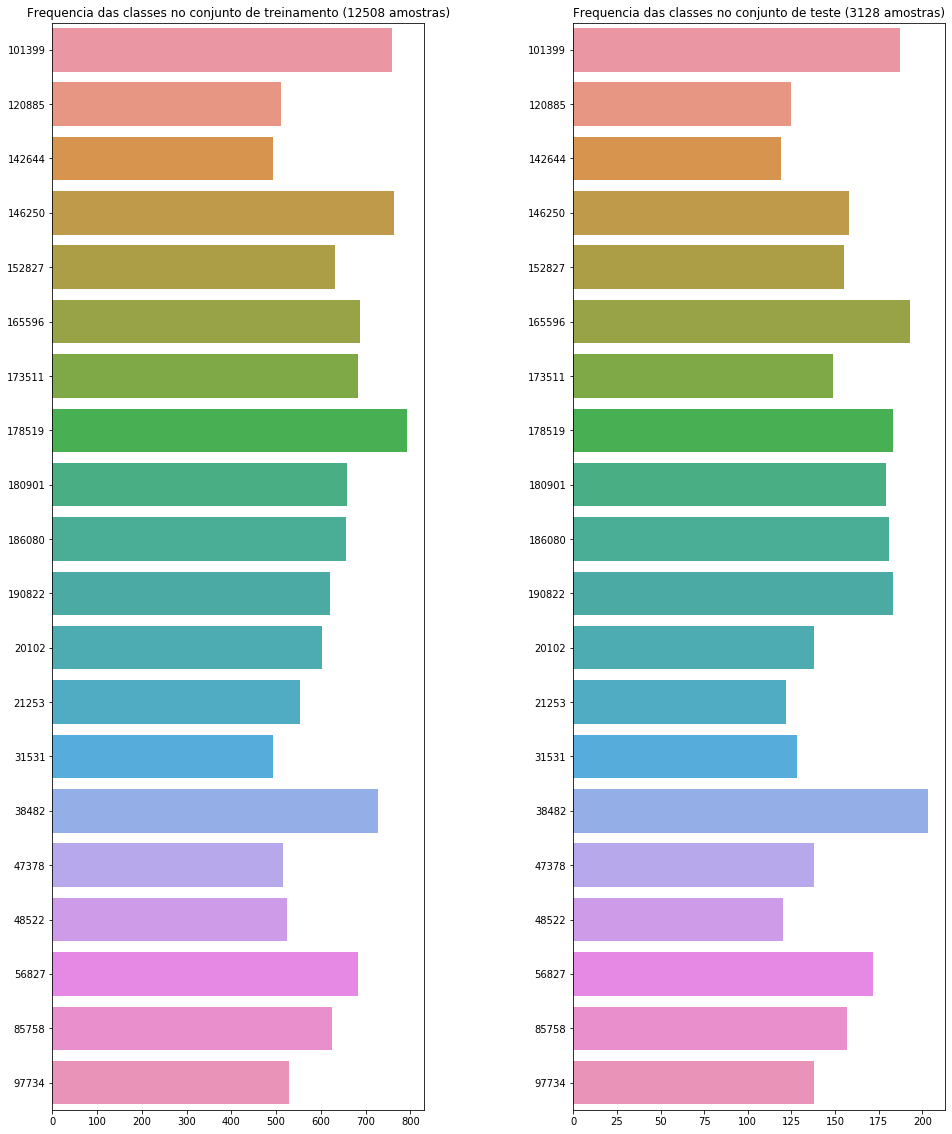

In [7]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(sample_generator.labels))
_, counts = np.unique(sample_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

# Preprocessamento das imagens de treino e validação

##Utilizaremos 20% da base de treinamento para validação

In [8]:
train_batch_size = 501 # Selecionar um divisor do número de amostras (1 3 5 15 17 51 85 167 255 501 835 2505 2839 8517 14195 42585)
val_batch_size = 379 # Selecionar um divisor do número de amostras (1 2 4 7 14 28 379 758 1516 2653 5306 10612)
test_batch_size = 215 # Selecionar um divisor do número de amostras (1 5 43 83 215 415 3569 17845)

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                    target_size = target_size,
                                                    batch_size = train_batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                         target_size = target_size,
                                                         batch_size = val_batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(base_path + "/subset_test",
                                                  target_size = target_size,
                                                  batch_size = test_batch_size,
                                                  class_mode = "categorical")

Found 10016 images belonging to 20 classes.
Found 2492 images belonging to 20 classes.
Found 3128 images belonging to 20 classes.


# Parâmetros para treinamento e validação

In [9]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

device = '/gpu:0'

epochs = 8

train_steps = train_generator.samples // train_batch_size

validation_steps = validation_generator.samples // val_batch_size

test_steps = test_generator.samples // test_batch_size

Instructions for updating:
Colocations handled automatically by placer.


# Funções de auxílio

In [10]:
df_resultado = pd.DataFrame(columns=["Rede", 
                                     "train_acc", 
                                     "train_loss", 
                                     "val_acc", 
                                     "val_loss"])
def salvar_resultado(rede,
                     train_acc,
                     train_loss,
                     val_acc,
                     val_loss,
                     df = df_resultado):
  
    df = df.append({"Rede" : rede,
                    "train_acc": train_acc,
                    "train_loss" : train_loss,
                    "val_acc": val_acc,
                    "val_loss": val_loss
                   }, 
                   ignore_index = True)
    return df

In [11]:
def train_model(model, 
                name, 
                train_g = train_generator, 
                validation_g = validation_generator, 
                factor = 1,
                train_epochs = epochs):
  train_g.reset()
  validation_g.reset()
  new_epoch = train_epochs * factor
  patience = new_epoch // 3
  with tf.device(device):
      return model.fit_generator(generator = train_g,
                                 steps_per_epoch = train_steps / factor,
                                 epochs = new_epoch,
                                 verbose = 1,
                                 validation_data = validation_g,
                                 validation_steps = validation_steps,
                                 callbacks=[callbacks.TerminateOnNaN(),
                                            callbacks.ReduceLROnPlateau(patience = patience),
                                            callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                                                      save_best_only=True,
                                                                      verbose=1),
                                            callbacks.EarlyStopping(patience = patience,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)])

In [12]:
def learning_curve_model(history):

  plt.figure(figsize=(16, 6))
  
  plt.subplot(121)  
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
   
  # summarize history for loss  
   
  plt.subplot(122)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
  plt.show()

In [13]:
def evaluate_generator_model(model, name, generator=validation_generator, steps=validation_steps):
  generator.reset()
  score_val = model.evaluate_generator(generator = generator, steps = steps)
  print('[' + name +'] loss:', score_val[0])
  print('[' + name +'] accuracy (NOT BALANCED):', score_val[1])
  return score_val

In [14]:
def predict_generator_model(model, generator = validation_generator, steps = validation_steps):
  generator.reset()

  y_val_final = []
  prediction_final = []
  for i in range(1, generator.samples // steps + 1):
    x_val, y_val = generator.next()
    probabilities = model.predict(x_val)

    prediction_final =  np.append(prediction_final, np.argmax(probabilities, axis=1))  
    y_val_final = np.append(y_val_final, np.argmax(y_val, axis=1))
    
  return y_val_final, prediction_final

In [15]:
def classification_report_model(y_val_final, prediction_final, labels=classes):
  print(metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= False))

  return metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= True)

In [16]:
def confusion_matrix_model(y_test, predictions, labels=classes):
  c = metrics.confusion_matrix(y_test, predictions)
  r = c / c.sum(axis=1).reshape(-1, 1)

  plt.figure(figsize=(18, 14))
  ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=labels, yticklabels=labels);
  plt.show()
  
  showing = 10

  ordered_by_scores = np.argsort(np.diag(r))
  labels_sorted_by_score = np.asarray(labels)[ordered_by_scores]

  print('\nClasses incorretamente classificadas pelo modelo, com maior frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[:showing],
                                          np.diag(r)[ordered_by_scores])))

  print('\nClasses incorretamente classificadas pelo modelo, com menor frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[::-1][:showing],
                                          np.diag(r)[ordered_by_scores[::-1]])))
  return r

In [17]:
def evaluate_model(model, name, generator = test_generator, steps = validation_steps):
  print('*** Prediction model - Part (1/5)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/5)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/5)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/5)****')
  val_score = evaluate_generator_model(model, name + '_val', generator, steps)
  train_score = evaluate_generator_model(model, name + '_train', train_generator, train_steps)
  
  print('*** Saving results - Part (5/5)****')
  salvar_resultado(name, train_score[1], train_score[0], val_score[1], val_score[0])

In [18]:
def evaluate_test_model(model, name, egenerator = validation_generator, steps = test_batch_size):
  print('*** Prediction model - Part (1/5)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/5)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/5)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/5)****')
  evaluate_generator_model(model, name + '_val', generator, steps)

# Rede *Homemade*

## Definindo a rede

In [19]:
def build_homemade():
  model = Sequential()

  model.add(Conv2D(filters = 10,
                      kernel_size = [3, 3],
                      name = "conv_1",
                      activation = "relu",
                      input_shape = input_shape))
  model.add(MaxPool2D(pool_size = [2, 2], name = "pool_1"))

  model.add(Conv2D(filters = 20,
                       kernel_size = [3, 3],
                       name = "conv_2",
                       activation = "relu"))
  model.add(Dropout(rate = 0.5, name = "do_1"))
  model.add(MaxPool2D(pool_size = [2, 2], name = "pool_2"))

  model.add(Flatten())
  model.add(Dense(units = 20,name = "dense_1", activation = 'softmax'))

  model.compile(optimizer = rms,
                    loss = 'categorical_crossentropy',
                    metrics=['accuracy'])

  model.summary()
  return model;

homemade_model = build_homemade()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 98, 98, 10)        280       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 49, 49, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 47, 47, 20)        1820      
_________________________________________________________________
do_1 (Dropout)               (None, 47, 47, 20)        0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 23, 23, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10580)             0         
___________________________

## Treinando o modelo

In [24]:
history_homemade = train_model(homemade_model, name =  'homemade-subset', factor = 50)

Epoch 1/400
1/0 [==============================================================================] - 12s 12s/step - loss: 2.4142 - acc: 0.3234 - val_loss: 2.5480 - val_acc: 0.2555

Epoch 00001: val_loss improved from inf to 2.54796, saving model to ./homemade-subset.weights.h5
Epoch 2/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.3356 - acc: 0.3313 - val_loss: 2.5230 - val_acc: 0.2915

Epoch 00002: val_loss improved from 2.54796 to 2.52302, saving model to ./homemade-subset.weights.h5
Epoch 3/400
1/0 [==============================================================================] - 12s 12s/step - loss: 2.4072 - acc: 0.2754 - val_loss: 2.5515 - val_acc: 0.2584

Epoch 00003: val_loss did not improve from 2.52302
Epoch 4/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.3130 - acc: 0.3214 - val_loss: 2.5202 - val_acc: 0.2598

Epoch 00004: val_loss improved from

1/0 [==============================================================================] - 10s 10s/step - loss: 2.2504 - acc: 0.3373 - val_loss: 2.5080 - val_acc: 0.2788

Epoch 00035: val_loss did not improve from 2.47765
Epoch 36/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.3134 - acc: 0.3094 - val_loss: 2.4981 - val_acc: 0.2792

Epoch 00036: val_loss did not improve from 2.47765
Epoch 37/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.3286 - acc: 0.3273 - val_loss: 2.5029 - val_acc: 0.2717

Epoch 00037: val_loss did not improve from 2.47765
Epoch 38/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.2816 - acc: 0.3174 - val_loss: 2.4903 - val_acc: 0.2958

Epoch 00038: val_loss did not improve from 2.47765
Epoch 39/400
1/0 [=======================================================================


Epoch 00070: val_loss did not improve from 2.46202
Epoch 71/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.2081 - acc: 0.3613 - val_loss: 2.4711 - val_acc: 0.2986

Epoch 00071: val_loss did not improve from 2.46202
Epoch 72/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.2367 - acc: 0.3333 - val_loss: 2.4987 - val_acc: 0.2754

Epoch 00072: val_loss did not improve from 2.46202
Epoch 73/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.3485 - acc: 0.2794 - val_loss: 2.4792 - val_acc: 0.2821

Epoch 00073: val_loss did not improve from 2.46202
Epoch 74/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.3559 - acc: 0.2715 - val_loss: 2.4769 - val_acc: 0.2858

Epoch 00074: val_loss did not improve from 2.46202
Epoch 75/400
1/0 [======


Epoch 00105: val_loss did not improve from 2.44925
Epoch 106/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.2570 - acc: 0.3234 - val_loss: 2.4710 - val_acc: 0.2762

Epoch 00106: val_loss did not improve from 2.44925
Epoch 107/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.1787 - acc: 0.3513 - val_loss: 2.4541 - val_acc: 0.3015

Epoch 00107: val_loss did not improve from 2.44925
Epoch 108/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.2456 - acc: 0.3234 - val_loss: 2.4537 - val_acc: 0.2863

Epoch 00108: val_loss did not improve from 2.44925
Epoch 109/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.1980 - acc: 0.3373 - val_loss: 2.4614 - val_acc: 0.2948

Epoch 00109: val_loss did not improve from 2.44925
Epoch 110/400
1/0 [=

1/0 [==============================================================================] - 10s 10s/step - loss: 2.1422 - acc: 0.3702 - val_loss: 2.4478 - val_acc: 0.3114

Epoch 00140: val_loss did not improve from 2.41087
Epoch 141/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.1754 - acc: 0.3533 - val_loss: 2.4493 - val_acc: 0.2885

Epoch 00141: val_loss did not improve from 2.41087
Epoch 142/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.1469 - acc: 0.3772 - val_loss: 2.4220 - val_acc: 0.3010

Epoch 00142: val_loss did not improve from 2.41087
Epoch 143/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0486 - acc: 0.4012 - val_loss: 2.4482 - val_acc: 0.3114

Epoch 00143: val_loss did not improve from 2.41087
Epoch 144/400
1/0 [===================================================================


Epoch 00175: val_loss did not improve from 2.40928
Epoch 176/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.1126 - acc: 0.4032 - val_loss: 2.4265 - val_acc: 0.2924

Epoch 00176: val_loss did not improve from 2.40928
Epoch 177/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.2062 - acc: 0.3533 - val_loss: 2.4328 - val_acc: 0.3010

Epoch 00177: val_loss did not improve from 2.40928
Epoch 178/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.1733 - acc: 0.3473 - val_loss: 2.4255 - val_acc: 0.3213

Epoch 00178: val_loss did not improve from 2.40928
Epoch 179/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0559 - acc: 0.3852 - val_loss: 2.3895 - val_acc: 0.3242

Epoch 00179: val_loss improved from 2.40928 to 2.38947, saving model to

1/0 [==============================================================================] - 11s 11s/step - loss: 2.1355 - acc: 0.3473 - val_loss: 2.4041 - val_acc: 0.3232

Epoch 00211: val_loss did not improve from 2.38947
Epoch 212/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.1251 - acc: 0.3852 - val_loss: 2.4260 - val_acc: 0.2906

Epoch 00212: val_loss did not improve from 2.38947
Epoch 213/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.1249 - acc: 0.3872 - val_loss: 2.3989 - val_acc: 0.3157

Epoch 00213: val_loss did not improve from 2.38947
Epoch 214/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.1503 - acc: 0.3752 - val_loss: 2.3913 - val_acc: 0.2982

Epoch 00214: val_loss did not improve from 2.38947
Epoch 215/400
1/0 [===================================================================


Epoch 00245: val_loss did not improve from 2.37167
Epoch 246/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0907 - acc: 0.3533 - val_loss: 2.3841 - val_acc: 0.3100

Epoch 00246: val_loss did not improve from 2.37167
Epoch 247/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0498 - acc: 0.3992 - val_loss: 2.3785 - val_acc: 0.3398

Epoch 00247: val_loss did not improve from 2.37167
Epoch 248/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.1034 - acc: 0.3792 - val_loss: 2.3938 - val_acc: 0.3176

Epoch 00248: val_loss did not improve from 2.37167
Epoch 249/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0818 - acc: 0.3812 - val_loss: 2.3879 - val_acc: 0.3265

Epoch 00249: val_loss did not improve from 2.37167
Epoch 250/400
1/0 [=


Epoch 00280: val_loss did not improve from 2.35189
Epoch 281/400
1/0 [==============================================================================] - 12s 12s/step - loss: 2.0790 - acc: 0.3872 - val_loss: 2.3901 - val_acc: 0.3017

Epoch 00281: val_loss did not improve from 2.35189
Epoch 282/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.0308 - acc: 0.3792 - val_loss: 2.3875 - val_acc: 0.3351

Epoch 00282: val_loss did not improve from 2.35189
Epoch 283/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.0961 - acc: 0.3872 - val_loss: 2.3877 - val_acc: 0.3076

Epoch 00283: val_loss did not improve from 2.35189
Epoch 284/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.0621 - acc: 0.4132 - val_loss: 2.3607 - val_acc: 0.3360

Epoch 00284: val_loss did not improve from 2.35189
Epoch 285/400
1/0 [=


Epoch 00315: val_loss did not improve from 2.34673
Epoch 316/400
1/0 [==============================================================================] - 11s 11s/step - loss: 2.0632 - acc: 0.4192 - val_loss: 2.3524 - val_acc: 0.3399

Epoch 00316: val_loss did not improve from 2.34673
Epoch 317/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0591 - acc: 0.3872 - val_loss: 2.3791 - val_acc: 0.3114

Epoch 00317: val_loss did not improve from 2.34673
Epoch 318/400
1/0 [==============================================================================] - 10s 10s/step - loss: 1.9917 - acc: 0.4132 - val_loss: 2.3593 - val_acc: 0.3365

Epoch 00318: val_loss did not improve from 2.34673
Epoch 319/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0357 - acc: 0.3892 - val_loss: 2.3526 - val_acc: 0.3171

Epoch 00319: val_loss did not improve from 2.34673
Epoch 320/400
1/0 [=


Epoch 00350: val_loss did not improve from 2.32041
Epoch 351/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0268 - acc: 0.3972 - val_loss: 2.3572 - val_acc: 0.3162

Epoch 00351: val_loss did not improve from 2.32041
Epoch 352/400
1/0 [==============================================================================] - 10s 10s/step - loss: 1.9196 - acc: 0.4451 - val_loss: 2.3498 - val_acc: 0.3360

Epoch 00352: val_loss did not improve from 2.32041
Epoch 353/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0543 - acc: 0.3932 - val_loss: 2.3370 - val_acc: 0.3346

Epoch 00353: val_loss did not improve from 2.32041
Epoch 354/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0086 - acc: 0.3972 - val_loss: 2.3202 - val_acc: 0.3540

Epoch 00354: val_loss improved from 2.32041 to 2.32021, saving model to


Epoch 00385: val_loss did not improve from 2.30659
Epoch 386/400
1/0 [==============================================================================] - 10s 10s/step - loss: 1.9101 - acc: 0.4731 - val_loss: 2.3207 - val_acc: 0.3500

Epoch 00386: val_loss did not improve from 2.30659
Epoch 387/400
1/0 [==============================================================================] - 10s 10s/step - loss: 1.9686 - acc: 0.3992 - val_loss: 2.3473 - val_acc: 0.3261

Epoch 00387: val_loss did not improve from 2.30659
Epoch 388/400
1/0 [==============================================================================] - 10s 10s/step - loss: 2.0360 - acc: 0.3872 - val_loss: 2.3397 - val_acc: 0.3474

Epoch 00388: val_loss did not improve from 2.30659
Epoch 389/400
1/0 [==============================================================================] - 10s 10s/step - loss: 1.9669 - acc: 0.4351 - val_loss: 2.3593 - val_acc: 0.3124

Epoch 00389: val_loss did not improve from 2.30659
Epoch 390/400
1/0 [=

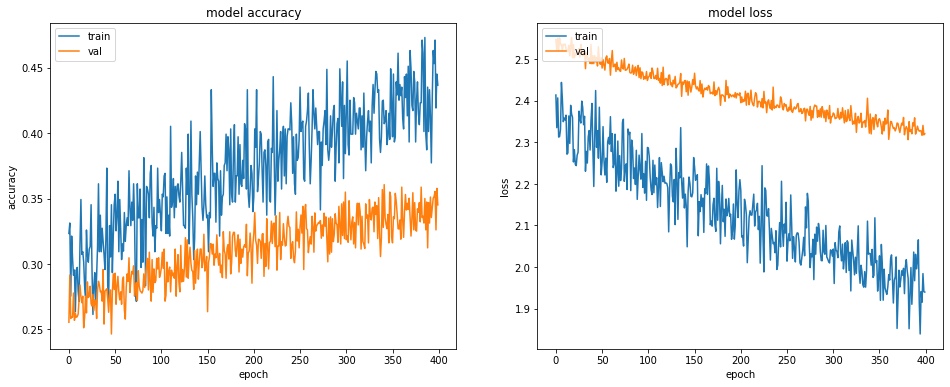

In [25]:
learning_curve_model(history_homemade)

## Avaliando modelo treinado

In [0]:
evaluate_model(homemade_model, 'Homemade')

*** Prediction model - Part (1/5)****


# ResNet18 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from classification_models.resnet import ResNet18, preprocess_input

def build_resNet18():
  model = ResNet18(input_shape = input_shape,
                   weights = "imagenet",
                   include_top=False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(100,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input, outputs = output)

  model.compile(loss ='categorical_crossentropy', 
                optimizer = rms, 
                metrics=['accuracy'])
  
  model.summary()
  return model

resNet18_feature_model = build_resNet18()

## Fine Tuning

### Definindo a rede

In [0]:
def build_resNet18_tuning():
  model = build_resNet18()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                optimizer = rms,
                metrics=['accuracy'])

  model.summary()
  return model

resNet18_tunning_model = build_resNet18_tuning()

### Treinando o modelo

In [0]:
history_resNet18_tuning = train_model(resNet18_tunning_model, name =  'ResNet18 - Tuning', factor = 10)

In [0]:
learning_curve_model(history_resNet18_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(resNet18_tunning_model, 'ResNet18 - Tuning')

# VGG16 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

def build_vgg16_feature():
  model = VGG16(input_shape = input_shape,
                      weights = "imagenet",
                      include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                      outputs = output)

  model.compile(loss ='categorical_crossentropy',
                      optimizer = rms,
                      metrics=['accuracy'])

  model.summary()
  return model

vgg16_feature_model = build_vgg16_feature()

## Fine Tuning

### Definindo a rede

In [0]:
def build_vgg16_tuning():
  model = build_vgg16_feature()

  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                optimizer = rms,
                metrics=['accuracy'])

  model.summary()
  return model
  
vgg16_tunning_model = build_vgg16_tuning();

### Treinando o modelo

In [0]:
history_vgg16_tuning = train_model(vgg16_tunning_model, name =  'VGG16 - Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_vgg16_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(vgg16_tunning_model, 'VGG16 - Tunning')

# InceptionV3 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input


def build_inceptionV3_feature_model():
  model = InceptionV3(input_shape = input_shape,
                                  weights = "imagenet",
                                  include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                            outputs = output)

  model.compile(loss ='categorical_crossentropy',
                            optimizer = rms,
                            metrics=['accuracy'])

  model.summary()
  return model

inceptionv3_feature_model = build_inceptionV3_feature_model()

## Fine Tuning

### Definindo a rede

In [0]:
def build_inceptionV3_tunning_model():
  model = build_inceptionV3_feature_model()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                            optimizer = rms,
                            metrics=['accuracy'])

  model.summary()
  return model

inceptionv3_tunning_model = build_inceptionV3_tunning_model()

### Treinando o modelo

In [0]:
history_inceptionv3_tuning = train_model(inceptionv3_tunning_model, name =  'InceptionV3 - Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_inceptionv3_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(inceptionv3_tunning_model, 'InceptionV3 - Tunning')

# MobileNetV2 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

def build_mobileNet_feature_model():
  model = MobileNetV2(input_shape = input_shape,
                                weights = "imagenet",
                                include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                          outputs = output)

  model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

  model.summary()
  return model

mobileNet_feature_model = build_mobileNet_feature_model()

## Fine Tuning

### Definindo a rede

In [0]:
def build_mobileNet_tunning_model():
  model = build_mobileNet_feature_model()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

  model.summary()
  return model

mobileNet_tunning_model = build_mobileNet_tunning_model()

### Treinando o modelo

In [0]:
history_mobileNet_tunning = train_model(mobileNet_tunning_model, name =  'MobileNet- Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_mobileNet_tunning)

### Avaliando modelo treinado

In [0]:
evaluate_model(mobileNet_tunning_model, 'MobileNet - Tunning')

# Avaliando as redes

## Comparando resultados das redes propostas

In [0]:
df_resultado.sort_values(by=["val_acc"])

## Avaliando no conjunto de teste(a melhor rede)

In [0]:
evaluate_test_model(history_resNet18_tuning, 'MobileNet - Tunning')